## scMetabolism analysis

In [ ]:
library(Seurat)
library(scMetabolism)
library(RColorBrewer)
library(ggplot2)

load( '~/DATA/code/myCode/subMyeloid.rdata')
cols = c('DC'="#7fc97f",'Monocyte'="#beaed4",'Macrophage'="#fdc086",'Hepatocytes'="#386cb0"
         ,"#f0027f","#a34e3b","#666666","#1b9e77","#d95f02"
         ,"#6c67a5","#d01b2a", "#43acde", "#efbd25","#1f78b4")
[subMyeloid$Label<-paste(subMyeloid$Celltype,subMyeloid$Group)]
DimPlot(subMyeloid,group.by = 'Celltype',cols = cols)

In [ ]:
##代谢分析
countexp.Seurat<-sc.metabolism.Seurat(obj = subMyeloid, method = "VISION", imputation = F, ncores = 8, metabolism.type = "KEGG")
##代谢活性矩阵
metabolism <- countexp.Seurat@assays$METABOLISM$score

##add KEGG as a new assay
subMyeloid[["KEGG"]] <- CreateAssayObject(counts = metabolism)
DefaultAssay(subMyeloid) <- 'KEGG'

##UMAP 可视化Oxidative phosphorylation通路活性
FeaturePlot(subMyeloid,features = 'Oxidative phosphorylation')+
scale_color_gradientn(colours = colorRampPalette(colors = brewer.pal(11, name = "YlOrRd"))(100))

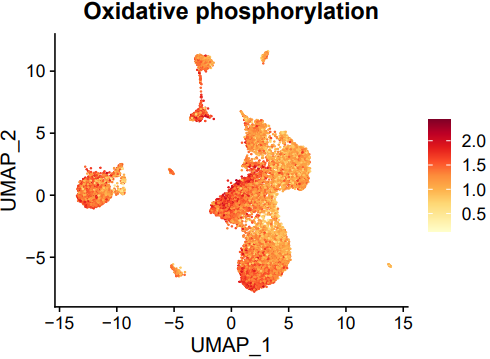

In [ ]:
##DotPlot可视化前20条通路代谢活性
list<-rownames(metabolism)[1:20]

DotPlot(subMyeloid,features = list,group.by = 'Label') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  scale_color_gradientn(colours = colorRampPalette(colors = rev(brewer.pal(11, name = "RdBu")))(100))+
  RotatedAxis()+ggplot2:::coord_flip()+xlab('KEGG Pathway')+ylab('Celltype')

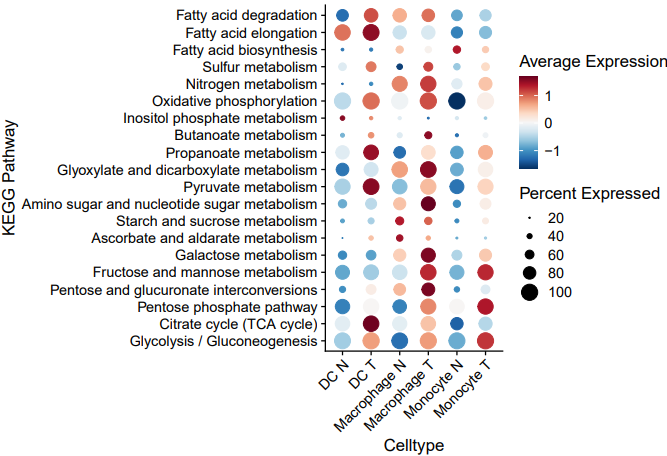

In [ ]:
##组间显著性检验
library(ggpubr)
my_comparisons <- list(c("DC N", "DC T"),c("Macrophage N", "Macrophage T"),c("Monocyte N", "Monocyte T"))

col2<-c("#f0027f","#a34e3b","#1b9e77","#d95f02"
        ,"#6c67a5","#d01b2a", "#43acde", "#efbd25","#1f78b4")
VlnPlot(subMyeloid,features = 'Citrate cycle (TCA cycle)',
        group.by = 'Label',pt.size = 0,cols = col2)+ 
        geom_boxplot(width=.2,col="black",fill="white",outlier.shape = NA)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        stat_compare_means(comparisons = my_comparisons, label = 'p.signif', size=6,label.y = 1.2) + 
        ylim(0, 1.4)+NoLegend()

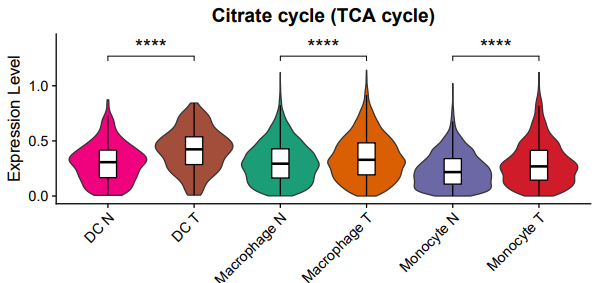

In [ ]:
##HEATMAP
sce_Metal_exp = countexp.Seurat
sce_Metal_exp$celltype = sce_Metal_exp$Label
mscore_data = data.frame(t(sce_Metal_exp@assays[["METABOLISM"]][["score"]]),sce_Metal_exp$celltype)
avg_sM=aggregate(mscore_data[,1:ncol(mscore_data)-1],list(mscore_data$sce_Metal_exp.celltype),mean)
rownames(avg_sM) = avg_sM$Group.1
avg_sM=data.frame(t(avg_sM[,-1]))
avg_sM$KEGG = rownames(sce_Metal_exp@assays[["METABOLISM"]][["score"]])
rownames(avg_sM)=avg_sM$KEGG
avg_sM$KEGG<-NULL

colors = colorRampPalette(c("navy", "white", "firebrick3"))(100)
avg_sM2<-avg_sM[1:40,]
pheatmap::pheatmap(avg_sM2,show_colnames = T,scale='row',cluster_cols = F,color = colors)

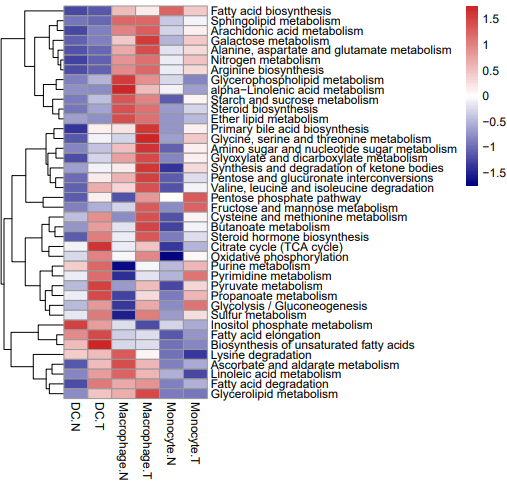

In [ ]:
save(subMyeloid,file = 'subMyeloid.rdata')